In [29]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

dataset = pd.read_csv('data/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [2]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

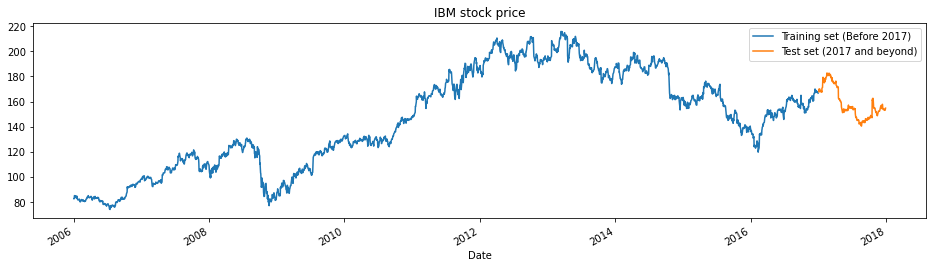

In [3]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [4]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
# 3 Demensional array
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

rl = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1)


In [8]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.5))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=['mean_squared_error'])

In [12]:
# Fitting to the training set
history = regressor.fit(X_train, Y_train, epochs=50,batch_size=32, callbacks=[rl])

# Saving weights
regressor.save_weights('weights.h5')

Epoch 1/50
85/85 [==============================] - 10s 122ms/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 2/50
85/85 [==============================] - 10s 122ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 3/50
85/85 [==============================] - 10s 121ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/50
85/85 [==============================] - 10s 120ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 5/50
85/85 [==============================] - 10s 120ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 6/50
85/85 [==============================] - 10s 122ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 7/50
85/85 [==============================] - 10s 121ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 8/50
85/85 [==============================] - 10s 121ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 9/50
85/85 [==============================] - 10s 121ms/step - loss: 0.0043 - mean_squared_error: 0.0043
E

In [9]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [10]:
regressor.load_weights('weights.h5')

In [33]:
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Y_pred = regressor.predict(X_test)
Y_pred = sc.inverse_transform(Y_pred)

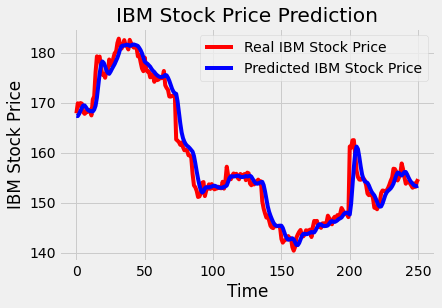

In [34]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()
    
plot_predictions(test_set, Y_pred)

In [13]:
mse = mean_squared_error(Y_test, Y_pred)

mse = math.sqrt(mse)
mse

158.57168162999184

In [19]:
Y_pred.shape

(251, 1)

In [20]:
Y_test.shape

(251, 1)